# A Shallow Shelf Approximation stabilization scheme

- This code simulates the flow of an ice shelf around an obstacle using the Shallow Shelf Approximation (SSA).
- We introduce the Thickness Stabilization Scheme (TSS), which allows greater stability and larger stable time steps.
- The core aspects of the TSS-stabilized model code below are introduced here.
- A full model description is to be found in *A numerical stabilization method for the shallow shelf approximation* by Tilda Westling Dolling, Clara Henry, and Josefin Ahlkrona.

## The Shallow Shelf Approximation (SSA)
### The SSA strong form
The Shallow Shelf Approximation for floating ice reads
$$
\begin{align}
    4 \frac{\partial}{\partial x}\biggl(\bar\eta \frac{\partial u_x}{\partial x} \biggl) 
    + 2\frac{\partial}{\partial x}\biggl( \bar\eta \frac{\partial u_y}{\partial y}  \biggl)
    + \frac{\partial}{\partial y}\biggl(\bar\eta \biggl(\frac{\partial u_x}{\partial y} + \frac{\partial u_y}{\partial x} \biggl)\biggl) = \frac{1}{2}\rho_i g  \biggl(1-\frac{\rho_i}{\rho_o} \biggl)\frac{\partial H^2}{\partial x},
    \\
    4 \frac{\partial}{\partial y}\biggl(\bar\eta \frac{\partial u_y}{\partial y} \biggl) 
    + 2\frac{\partial}{\partial y}\biggl( \bar\eta \frac{\partial u_x}{\partial x}  \biggl)
    + \frac{\partial}{\partial x}\biggl(\bar\eta \biggl(\frac{\partial u_x}{\partial y} + \frac{\partial u_y}{\partial x} \biggl)\biggl) = \frac{1}{2}\rho_i g  \biggl(1-\frac{\rho_i}{\rho_o} \biggl)\frac{\partial H^2}{\partial y},
\end{align}\tag{1}
$$
where $\mathbf{u} = (u_x, u_y)$ is the horizontal velocity vector, $H$ is the ice thickness, $\rho_i$ is the ice density, $\rho_o$ is the ocean density, and $g$ is the gravitational constant. 

The vertically-averaged viscosity is
$$
\bar\eta = \frac{1}{2} A^{-1/n} H \left( \frac{1}{2}\|\dot{\boldsymbol{\varepsilon}}\|^2_F + \dot{\varepsilon}_0^2 \right)^{(1-n)/(2n)},\tag{2}
$$
where $A$ is the ice fluidity, $\dot{\boldsymbol{\varepsilon}}$ is the strain rate tensor, $\|\cdot|^2_F$ is the Frobenius norm and $\dot{\varepsilon}_0^2$ is a regularization term.
### The SSA weak form
For simplicity, we define the tensor
$$
\mathbf{T} = \begin{pmatrix} \bar\eta  \big( 4 \frac{\partial u_x}{\partial x} + 2 \frac{\partial u_y}{\partial y} \big) & \bar\eta  \big( \frac{\partial u_x}{\partial y} + \frac{\partial u_y}{\partial x} \big) \\ \bar\eta  \big( \frac{\partial u_x}{\partial y} + \frac{\partial u_y}{\partial x} \big) & \bar\eta  \big( 2 \frac{\partial u_x}{\partial x} + 4 \frac{\partial u_y}{\partial y} \big) \end{pmatrix},\tag{3}
$$
with a scaled gravitational term,
$$
\rho' = \frac{1}{2}\rho_i g \bigg(1-\frac{\rho_i}{\rho_o} \bigg).\tag{4}
$$
The SSA momentum equations can be rewritten as
$$
\nabla \cdot \mathbf{T} = \rho' \nabla H^2.\tag{5}
$$

In weak form, the SSA momentum equations read
$$
\int_{\Omega}\mathbf{T}(\mathbf{u}) : \nabla \mathbf{v} ~d\Omega = \rho' \int_{\Omega} H^2 \nabla\cdot \mathbf{v} ~d\Omega \quad \forall  \, \mathbf{v} \in \boldsymbol{\chi},\tag{6}
$$
where $\mathbf{v} \in \boldsymbol{\chi}$ is a test function in an appropriate Sobolov space.

## The thickness evolution equation

The geometry evolution is governed by the thickness evolution equation,
$$
\frac{\partial H}{\partial t} = - \nabla \cdot (H \mathbf{u}) + a_s - a_b,\tag{8}
$$

The semi-implicit Euler time discretization reads
$$
H_{k+1} + \Delta t \nabla \cdot (H_{k+1} \mathbf{u}_k) = H_k + \Delta t (a_s - a_b),\tag{9}
$$
where $H_k$ is the ice thickness at time step $k$, $H_{k+1}$ is the ice thickness at the next time step, $k+1$, $a_s$ is the surface accumulation rate and $a_b$ is the melt rate. Eq. (9) is used in this model to evolve the geometry of the ice.

The explicit Euler time discretization reads
$$
H_{k+1} = H_k - \Delta t \nabla \cdot (H_k \mathbf{u}_k) + \Delta t (a_s - a_b).\tag{10}
$$
This formulation is adapted to construct the numerical stabilization scheme.

## The Thickness Stabilization Scheme (TSS)

Multiplying Eq. (8) by $2 H$, an expression is found for the ice squared ice thickness at the next time step, $H_{k+1}^{2}$. Using an explicit Euler time discretization,
$$
H^2_{k+1} = H^2_k - 2 \Delta t H_k \nabla \cdot (H_k \mathbf{u}) + 2 \Delta t (a_s - a_b).
$$

We use this expression to mimick treating the right-hand side of Eq. (5) implictly. The TSS-stabilized SSA equations therefore read
$$
\begin{aligned}
    \int_{\Omega} \mathbf{T} : \nabla \mathbf{v} ~d\Omega &+ \int_{\Omega} 2 \theta \Delta t H_k \nabla \cdot (H_k \mathbf{u})\nabla\cdot \mathbf{v} ~d\Omega \\
    &= \rho' \int_{\Omega} \big[H^2_k  - 2 \theta \Delta t H_k (a_b - a_s )\big] \nabla\cdot \mathbf{v} ~d\Omega,
\end{aligned}
$$
where the parameter $\theta \in [0,1]$ allows the user to perform a simulation with ($\theta = 1$) or without ($\theta = 0$) TSS.


In [1]:
from fenics import *
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from constants import *
from SSA_functions import *
from FEM_setup import *


In [2]:
start = time.time()

for i in range(num_TS):
    change=100
    tol=1e-5
    iter_sim=0
    maxiter=200

    while change>tol and iter_sim<maxiter:
        iter_sim=iter_sim+1
        if theta != 0:
            # x-momentum eq.:
            a =  4*dot(mu*u1.dx(0), v1.dx(0))*dx \
                + 2*dot(mu*u2.dx(1), v1.dx(0))*dx \
                + dot(mu*u1.dx(1)+mu*u2.dx(0), v1.dx(1))*dx \
                + theta*dt*rho*g*dot(thick*(u1*thick).dx(0) \
                + thick*(u2*thick).dx(1), v1.dx(0))*dx
            L = 0.5*rho*g*dot(thick*thick, v1.dx(0))*dx \
                        
            # y-momentum eq.:
            a += 4*dot(mu*u2.dx(1), v2.dx(1))*dx \
                + 2*dot(mu*u1.dx(0), v2.dx(1))*dx \
                + dot(mu*u1.dx(1)+mu*u2.dx(0), v2.dx(0))*dx \
                + theta*dt*rho*g*dot(thick*(u1*thick).dx(0) \
                + thick*(u2*thick).dx(1), v2.dx(1))*dx
            L += 0.5*rho*g*dot(thick*thick, v2.dx(1))*dx  \
                + theta*(a_s - a_b)*rho*g*dt*dot(thick, v2.dx(1))*dx
        else:
            a =  4*dot(mu*u1.dx(0), v1.dx(0))*dx \
               + 2*dot(mu*u2.dx(1), v1.dx(0))*dx \
               + dot(mu*u1.dx(1)+mu*u2.dx(0), v1.dx(1))*dx\
               + 4*dot(mu*u2.dx(1), v2.dx(1))*dx \
               + 2*dot(mu*u1.dx(0), v2.dx(1))*dx \
               + dot(mu*u1.dx(1)+mu*u2.dx(0), v2.dx(0))*dx
            L = 0.5*rho*g*dot(thick*thick,v1.dx(0))*dx \
              + 0.5*rho*g*dot(thick*thick,v2.dx(1))*dx

        # Compute solution
        uvecold=uvec.copy(deepcopy=True)
        (uxold,uyold)=split(uvecold)
        solve(a == L, uvec, [bc1,bc2,bc4,bc6,bc7,bc8])
        mu=viscosity(ux,uy,thick)
        change = norm(uvec.vector()-uvecold.vector())/norm(uvec.vector())
        print(change)
        
    print("Solving thickness evolution now...")
    
    vel = as_vector([ux, uy])
    vnorm = sqrt(dot(vel, vel) + DOLFIN_EPS)
    mu_art = 0.1 * h * vnorm
    
    F = (
        thick_new * phi * dx \
        - thick * phi * dx \
        + dt * dot((ux * thick_new).dx(0), phi) * dx \
        + dt * dot((uy * thick_new).dx(1), phi) * dx \
        + dt * dot(( -a_s + a_b ), phi) * dx \
        # Artifical viscosity
        + dt * mu_art * dot(grad(thick_new), grad(phi)) * dx
    )

    H = Function(V)
    solve(lhs(F) == rhs(F), H, [H_bc])
    thick = interpolate(H, V)
    
    # Minimum thickness constraint:
    thick.vector().set_local(np.maximum(thick.vector().get_local(), 10.0))
    thick.vector().apply("insert")
    print("Finished solving thickness evolution...")
    print("Year: ", (i+1)*dt)
    
end = time.time()


1.0Solving linear variational problem.

Solving linear variational problem.
0.21501726014102068
Solving linear variational problem.
0.07158785444171836
Solving linear variational problem.
0.027618456262456712
Solving linear variational problem.
0.011502645604537719
Solving linear variational problem.
0.005036525052771695
Solving linear variational problem.
0.002300321283410655
Solving linear variational problem.
0.0010942961301358698
Solving linear variational problem.
0.0005416420047073937
Solving linear variational problem.
0.0002780878855087767
Solving linear variational problem.
0.0001473324182013282
Solving linear variational problem.
8.005879841692533e-05
Solving linear variational problem.
4.4359117001315476e-05
2.4940619935293674e-05
Solving linear variational problem.
Solving linear variational problem.
1.4176183031855002e-05
Solving linear variational problem.
8.123632981238242e-06
Solving thickness evolution now...
Solving linear variational problem.
Finished solving thickne

Solving linear variational problem.
0.00011492128412410852
Solving linear variational problem.
5.601216443270308e-05
Solving linear variational problem.
2.7503515543937975e-05
1.3597930684749357e-05
Solving linear variational problem.
6.765993426967353e-06
Solving thickness evolution now...
Finished solving thickness evolution...
Year:  100
Solving linear variational problem.
Solving linear variational problem.
0.006123369523692359Solving linear variational problem.

Solving linear variational problem.
0.0036697354507018625
0.001590754289938158
Solving linear variational problem.
0.0007429892061720526
Solving linear variational problem.
0.0003539878536066045Solving linear variational problem.

Solving linear variational problem.
0.00017064642001309716
Solving linear variational problem.
8.303172063998822e-05
Solving linear variational problem.
4.073121950537667e-05
Solving linear variational problem.
2.0129003033110807e-05
Solving linear variational problem.
1.0015498753375719e-05
5.01

Finished solving thickness evolution...Solving linear variational problem.

Year:  250
Solving linear variational problem.
3.3137975035889516e-05
Solving linear variational problem.
1.671166989877466e-05
Solving linear variational problem.
7.448558177514379e-06
Solving thickness evolution now...
Solving linear variational problem.
Finished solving thickness evolution...
Year:  260
Solving linear variational problem.
2.1114918579122534e-05
Solving linear variational problem.
1.2560022790252626e-05
Solving linear variational problem.
5.629917899996666e-06
Solving thickness evolution now...
Finished solving thickness evolution...
Year:  270
Solving linear variational problem.
1.4851526906127286e-05
Solving linear variational problem.
8.988887422231154e-06
Solving thickness evolution now...
Solving linear variational problem.
Finished solving thickness evolution...
Year:  280
Solving linear variational problem.
Solving linear variational problem.
7.985545331087042e-06
Solving thickness evo

4.220273079460304e-10Solving linear variational problem.

Solving thickness evolution now...
Solving linear variational problem.
Finished solving thickness evolution...
Year:  700
Solving linear variational problem.
3.372145668716691e-10
Solving thickness evolution now...
Solving linear variational problem.
Finished solving thickness evolution...
Year:  710
Solving linear variational problem.
2.6912650009012195e-10
Solving thickness evolution now...
Solving linear variational problem.
Finished solving thickness evolution...
Year:  720
Solving linear variational problem.
2.1450757082500476e-10
Solving thickness evolution now...
Solving linear variational problem.
Finished solving thickness evolution...
Year:  730
Solving linear variational problem.
1.7075494460127435e-10
Solving thickness evolution now...
Solving linear variational problem.
Finished solving thickness evolution...
Year:  740
Solving linear variational problem.
1.3576695792354315e-10
Solving thickness evolution now...
Sol

Solving linear variational problem.
3.2284296470572865e-14
Solving thickness evolution now...
Finished solving thickness evolution...
Year:  1160
Solving linear variational problem.
4.3764413336171795e-14
Solving thickness evolution now...
Solving linear variational problem.
Solving linear variational problem.
Finished solving thickness evolution...
Year:  1170
Solving linear variational problem.
4.900343722150456e-14
Solving thickness evolution now...
Solving linear variational problem.
Finished solving thickness evolution...
Year:  1180
Solving linear variational problem.
2.5838506103466098e-14
Solving thickness evolution now...
Solving linear variational problem.
Finished solving thickness evolution...
Year:  1190
Solving linear variational problem.
4.587896570449677e-14
Solving thickness evolution now...
Solving linear variational problem.
Finished solving thickness evolution...
Year:  1200
Solving linear variational problem.
3.256406593628506e-14
Solving thickness evolution now...

Solving linear variational problem.
Finished solving thickness evolution...
Year:  1610
Solving linear variational problem.
2.618498942943487e-14
Solving thickness evolution now...
Solving linear variational problem.
Solving linear variational problem.
Finished solving thickness evolution...
Year:  1620
Solving linear variational problem.
2.4624901997030694e-14
Solving thickness evolution now...
Solving linear variational problem.
Finished solving thickness evolution...
Year:  1630
Solving linear variational problem.
1.6506989983305125e-14
Solving thickness evolution now...
Solving linear variational problem.
Finished solving thickness evolution...
Year:  1640
Solving linear variational problem.
1.3894050359748968e-14
Solving thickness evolution now...
Solving linear variational problem.
Finished solving thickness evolution...
Year:  1650
Solving linear variational problem.
2.6179383491124923e-14
Solving thickness evolution now...
Finished solving thickness evolution...
Year:  1660
Sol

In [5]:
print("Runtime: {:.4f} seconds".format(end - start))

Runtime: 45.2642 seconds


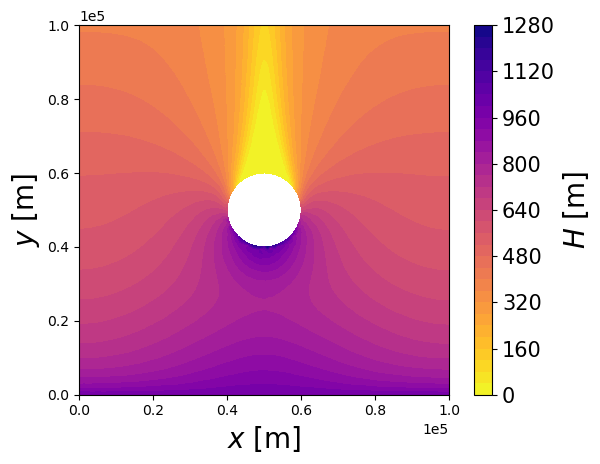

In [3]:
plot_field(thick, label=r'$H$ [m]')

Object cannot be plotted directly, projecting to piecewise linears.


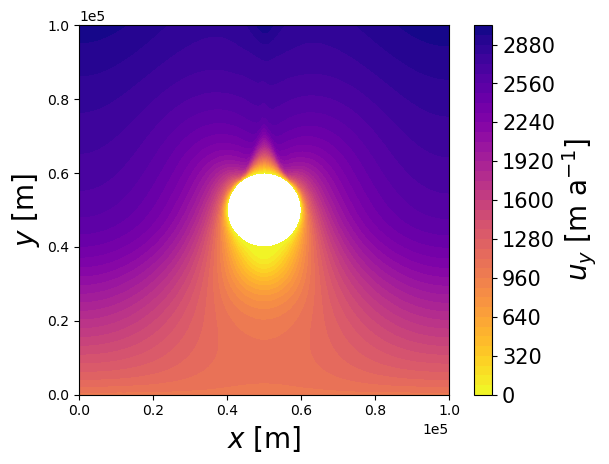

In [4]:
plot_field(uy, label=r'$u_y$ [m a$^{-1}$]')